In [2]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm

def parse_tfrecord(record_bytes):
    """Parse TFRecord using the correct feature description."""
    
    feature_description = {
        # State features for 128 agents
        "state/id": tf.io.FixedLenFeature([128], tf.float32, default_value=None),
        "state/type": tf.io.FixedLenFeature([128], tf.float32, default_value=None),
        "state/is_sdc": tf.io.FixedLenFeature([128], tf.int64, default_value=None),
        "state/tracks_to_predict": tf.io.FixedLenFeature([128], tf.int64, default_value=None),
        
        # Current state (shape: [128, 1])
        "state/current/x": tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
        "state/current/y": tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
        "state/current/bbox_yaw": tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
        "state/current/valid": tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
        "state/current/width": tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
        "state/current/length": tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
        
        # Past state (shape: [128, 10])
        "state/past/x": tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
        "state/past/y": tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
        "state/past/bbox_yaw": tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
        "state/past/valid": tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
        
        # Future state (shape: [128, 80])
        "state/future/x": tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
        "state/future/y": tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
        "state/future/bbox_yaw": tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
        "state/future/valid": tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
        
        # Scenario ID
        "scenario/id": tf.io.FixedLenFeature([1], tf.string, default_value=None),
    }
    
    return tf.io.parse_single_example(record_bytes, feature_description)

def process_trajectories(tfrecord_path, output_path, max_samples=None):
    """Process TFRecord file and save as NPZ."""
    
    # Create TFRecord dataset
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    
    # Lists to store all scenes
    all_scenes = []
    
    # Process each example (scene)
    for i, record_bytes in tqdm(enumerate(dataset)):
        if max_samples and i >= max_samples:
            break
            
        try:
            # Parse the record
            example = parse_tfrecord(record_bytes)
            
            # Process each agent in the scene
            n_agents = 128  # Fixed size from your feature description
            
            # Combine past and current for history
            history_x = np.concatenate([
                example['state/past/x'].numpy(),
                example['state/current/x'].numpy()
            ], axis=1)  # Shape: [128, 11]
            
            history_y = np.concatenate([
                example['state/past/y'].numpy(),
                example['state/current/y'].numpy()
            ], axis=1)  # Shape: [128, 11]
            
            history_valid = np.concatenate([
                example['state/past/valid'].numpy(),
                example['state/current/valid'].numpy()
            ], axis=1)  # Shape: [128, 11]
            
            # Get future trajectories
            future_x = example['state/future/x'].numpy()  # Shape: [128, 80]
            future_y = example['state/future/y'].numpy()  # Shape: [128, 80]
            future_valid = example['state/future/valid'].numpy()  # Shape: [128, 80]
            
            # Create scene data
            scene_data = {
                'file_name': os.path.basename(tfrecord_path),
                'scenario_id': example['scenario/id'].numpy()[0].decode(),
                'agent_id': example['state/id'].numpy(),
                'agent_type': example['state/type'].numpy(),
                'agent_valid': example['state/current/valid'].numpy()[:, 0],
                'width': example['state/current/width'].numpy()[:, 0],
                'length': example['state/current/length'].numpy()[:, 0],
                'history/xy': np.stack([history_x, history_y], axis=2),  # Shape: [128, 11, 2]
                'history/yaw': np.concatenate([
                    example['state/past/bbox_yaw'].numpy(),
                    example['state/current/bbox_yaw'].numpy()
                ], axis=1),
                'history/valid': history_valid,
                'future/xy': np.stack([future_x, future_y], axis=2),  # Shape: [128, 80, 2]
                'future/yaw': example['state/future/bbox_yaw'].numpy(),
                'future/valid': future_valid
            }
            
            # Save individual scene
            np.savez_compressed(output_path, **scene_data)
            print(f"\nProcessed data saved to {output_path}")
            print(f"Number of agents: {n_agents}")
            
        except Exception as e:
            print(f"Error processing record {i}: {str(e)}")
            continue

def verify_npz_data(npz_path):
    """Verify the processed NPZ file."""
    data = np.load(npz_path)
    
    print("\nData Verification:")
    print("==================")
    
    # Print shapes
    for key in data.files:
        print(f"{key}: {data[key].shape}")
        
        # Print sample values for key fields
        if key in ['history/xy', 'future/xy']:
            print(f"\nSample {key} values (first agent, first 5 timesteps):")
            print(data[key][0, :5])


def process_multiple_tfrecords(tfrecord_paths, output_path):
    """Process multiple TFRecord files and combine into one NPZ."""
    
    combined_data = None
    
    for tfrecord_path in tfrecord_paths:
        dataset = tf.data.TFRecordDataset(tfrecord_path)
        print(f"\nProcessing: {tfrecord_path}")
        
        for i, record_bytes in tqdm(enumerate(dataset)):
            try:
                example = parse_tfrecord(record_bytes)
                
                # Create scene data
                history_x = np.concatenate([
                    example['state/past/x'].numpy(),
                    example['state/current/x'].numpy()
                ], axis=1)
                
                history_y = np.concatenate([
                    example['state/past/y'].numpy(),
                    example['state/current/y'].numpy()
                ], axis=1)
                
                history_valid = np.concatenate([
                    example['state/past/valid'].numpy(),
                    example['state/current/valid'].numpy()
                ], axis=1)
                
                scene_data = {
                    'file_name': os.path.basename(tfrecord_path),
                    'scenario_id': example['scenario/id'].numpy()[0].decode(),
                    'agent_id': example['state/id'].numpy(),
                    'agent_type': example['state/type'].numpy(),
                    'agent_valid': example['state/current/valid'].numpy()[:, 0],
                    'width': example['state/current/width'].numpy()[:, 0],
                    'length': example['state/current/length'].numpy()[:, 0],
                    'history/xy': np.stack([history_x, history_y], axis=2),
                    'history/yaw': np.concatenate([
                        example['state/past/bbox_yaw'].numpy(),
                        example['state/current/bbox_yaw'].numpy()
                    ], axis=1),
                    'history/valid': history_valid,
                    'future/xy': np.stack([
                        example['state/future/x'].numpy(),
                        example['state/future/y'].numpy()
                    ], axis=2),
                    'future/yaw': example['state/future/bbox_yaw'].numpy(),
                    'future/valid': example['state/future/valid'].numpy()
                }
                
                # For the first scene, initialize the combined data
                if combined_data is None:
                    combined_data = {k: [] for k in scene_data.keys()}
                
                # Append data
                for key in combined_data:
                    combined_data[key].append(scene_data[key])
                
            except Exception as e:
                print(f"Error processing record {i} from {tfrecord_path}: {str(e)}")
                continue
    
    # Convert lists to arrays
    final_data = {}
    for key in combined_data:
        if combined_data[key]:  # Check if list is not empty
            try:
                final_data[key] = np.concatenate(combined_data[key], axis=0)
            except:
                final_data[key] = np.array(combined_data[key])
    
    # Save combined data
    np.savez_compressed(output_path, **final_data)
    print(f"\nSaved combined data to: {output_path}")
    
    # Print data shapes
    print("\nFinal data shapes:")
    for key, value in final_data.items():
        print(f"{key}: {value.shape}")

def verify_trajectory_continuity(history_xy, future_xy, history_valid, future_valid):
    """Verify that trajectories are continuous at the transition point."""
    # Check last point of history matches first point of future
    last_history = history_xy[history_valid][-1]
    first_future = future_xy[future_valid][0]
    
    diff = np.linalg.norm(last_history - first_future)
    print(f"Gap between history and future: {diff}")
    return diff < 1.0  # Threshold for acceptable difference

def process_trajectories(tfrecord_path, output_path, max_samples=None):
    """Process TFRecord file and save as NPZ with verification."""
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    
    for i, record_bytes in tqdm(enumerate(dataset)):
        try:
            example = parse_tfrecord(record_bytes)
            
            # Combine past and current for history
            history_x = np.concatenate([
                example['state/past/x'].numpy(),
                example['state/current/x'].numpy()
            ], axis=1)
            
            history_y = np.concatenate([
                example['state/past/y'].numpy(),
                example['state/current/y'].numpy()
            ], axis=1)
            
            history_xy = np.stack([history_x, history_y], axis=2)
            future_xy = np.stack([
                example['state/future/x'].numpy(),
                example['state/future/y'].numpy()
            ], axis=2)
            
            # Print sample trajectories for verification
            if i == 0:  # First example
                print("\nSample trajectory verification:")
                print("History last 3 points:")
                print(history_xy[0, -3:])
                print("\nFuture first 3 points:")
                print(future_xy[0, :3])
                
                # Verify continuity
                history_valid = np.concatenate([
                    example['state/past/valid'].numpy(),
                    example['state/current/valid'].numpy()
                ], axis=1)
                future_valid = example['state/future/valid'].numpy()
                
                is_continuous = verify_trajectory_continuity(
                    history_xy[0], future_xy[0],
                    history_valid[0], future_valid[0]
                )
                print(f"Trajectory is continuous: {is_continuous}")
            
            # Create scene data dictionary
            scene_data = {
                'file_name': os.path.basename(tfrecord_path),
                'scenario_id': example['scenario/id'].numpy()[0].decode(),
                'agent_id': example['state/id'].numpy(),
                'agent_type': example['state/type'].numpy(),
                'agent_valid': example['state/current/valid'].numpy()[:, 0],
                'width': example['state/current/width'].numpy()[:, 0],
                'length': example['state/current/length'].numpy()[:, 0],
                'history/xy': history_xy,
                'history/yaw': np.concatenate([
                    example['state/past/bbox_yaw'].numpy(),
                    example['state/current/bbox_yaw'].numpy()
                ], axis=1),
                'history/valid': history_valid,
                'future/xy': future_xy,
                'future/yaw': example['state/future/bbox_yaw'].numpy(),
                'future/valid': future_valid
            }
            
            np.savez_compressed(output_path, **scene_data)
            
        except Exception as e:
            print(f"Error processing record {i}: {str(e)}")
            continue

def main():
    tfrecord_paths = [
        "uncompressed_tf_example_training_training_tfexample.tfrecord-00003-of-01000",
        "uncompressed_tf_example_training_training_tfexample.tfrecord-00004-of-01000",
        "uncompressed_tf_example_training_training_tfexample.tfrecord-00005-of-01000",

    ]
    
    output_dir = "processed_data"
    os.makedirs(output_dir, exist_ok=True)
    
    for tfrecord_path in tfrecord_paths:
        output_path = os.path.join(output_dir, 
                                 f"processed_{os.path.basename(tfrecord_path)}.npz")
        print(f"\nProcessing: {tfrecord_path}")
        process_trajectories(tfrecord_path, output_path)

if __name__ == "__main__":
    main()




Processing: uncompressed_tf_example_training_training_tfexample.tfrecord-00003-of-01000


0it [00:00, ?it/s]


Sample trajectory verification:
History last 3 points:
[[5298.8584 2924.8767]
 [5299.8667 2924.766 ]
 [5300.881  2924.682 ]]

Future first 3 points:
[[5301.9346 2924.6147]
 [5302.975  2924.5686]
 [5304.0396 2924.5369]]
Gap between history and future: 11.1380615234375
Trajectory is continuous: False


483it [00:01, 360.97it/s]



Processing: uncompressed_tf_example_training_training_tfexample.tfrecord-00004-of-01000


37it [00:00, 367.83it/s]


Sample trajectory verification:
History last 3 points:
[[-8067.7646 -2025.6146]
 [-8067.8916 -2025.8944]
 [-8068.0015 -2026.1504]]

Future first 3 points:
[[-8068.126  -2026.4282]
 [-8068.277  -2026.7365]
 [-8068.4263 -2027.0366]]
Gap between history and future: 2.8463239669799805
Trajectory is continuous: False


456it [00:01, 389.83it/s]



Processing: uncompressed_tf_example_training_training_tfexample.tfrecord-00005-of-01000


40it [00:00, 391.61it/s]


Sample trajectory verification:
History last 3 points:
[[-977.9967  -174.42534]
 [-978.3131  -174.44786]
 [-978.5997  -174.47461]]

Future first 3 points:
[[-978.8922  -174.48543]
 [-979.1308  -174.49658]
 [-979.47705 -174.52295]]
Gap between history and future: 3.057135820388794
Trajectory is continuous: False


517it [00:01, 398.77it/s]


In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def visualize_npz_data(npz_path, scene_idx=0, max_agents=1):
    """
    Visualize trajectory data from NPZ file.
    
    Args:
        npz_path: Path to the NPZ file
        scene_idx: Which scene to visualize if multiple scenes exist
        max_agents: Maximum number of agents to visualize (to avoid cluttering)
    """
    # Load the data
    data = np.load(npz_path)
    
    # Create a figure
    plt.figure(figsize=(15, 10))
    
    # Plot for each agent (up to max_agents)
    valid_agents = np.where(data['agent_valid'])[0]
    agents_to_plot = valid_agents[:max_agents]
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(agents_to_plot)))
    
    for idx, agent_idx in enumerate(agents_to_plot):
        # Get agent dimensions
        width = data['width'][agent_idx]
        length = data['length'][agent_idx]
        
        # Plot history trajectory
        history = data['history/xy'][agent_idx]
        history_valid = data['history/valid'][agent_idx]
        valid_history = history[history_valid == 1]
        
        plt.plot(valid_history[:, 0], valid_history[:, 1], 
                'o-', color=colors[idx], alpha=0.5, 
                label=f'History Agent {agent_idx}')
        
        # Plot future trajectory
        future = data['future/xy'][agent_idx]
        future_valid = data['future/valid'][agent_idx]
        valid_future = future[future_valid == 1]
        
        plt.plot(valid_future[:, 0], valid_future[:, 1], 
                '--', color=colors[idx], alpha=0.5,
                label=f'Future Agent {agent_idx}')
        
        # Plot current position (last point of history) with vehicle rectangle
        current_pos = history[-1]
        current_yaw = data['history/yaw'][agent_idx][-1]
        
        # Create rectangle for vehicle
        rect = Rectangle(
            (current_pos[0] - length/2, current_pos[1] - width/2),
            length, width,
            angle=np.degrees(current_yaw),
            color=colors[idx],
            alpha=0.7
        )
        plt.gca().add_patch(rect)
        
        # Add agent type information
        agent_type = data['agent_type'][agent_idx]
        plt.annotate(f'Type: {agent_type}', 
                    (current_pos[0], current_pos[1]),
                    xytext=(10, 10), 
                    textcoords='offset points')
    
    plt.title('Trajectory Visualization\nDots: History, Dashed: Future, Rectangles: Current Position')
    plt.xlabel('X Position (meters)')
    plt.ylabel('Y Position (meters)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Print additional information
    print(f"\nScene Information:")
    print(f"Scenario ID: {data['scenario_id']}")
    print(f"Total number of valid agents: {len(valid_agents)}")
    print(f"Time spans:")
    print(f"- History: {data['history/xy'].shape[1]} timesteps")
    print(f"- Future: {data['future/xy'].shape[1]} timesteps")
    
    plt.tight_layout()
    plt.show()

# Add this to your main() function:
def main():
    # ... [previous code] ...
    
    # After processing, visualize the first processed file
    output_path = os.path.join("processed_data", 
                              f"processed_{os.path.basename(tfrecord_paths[0])}.npz")
    print("\nVisualizing processed data...")
    visualize_npz_data(output_path)


Scene Information:
Scenario ID: 74f32d2edbd3bfd8
Total number of valid agents: 11
Time spans:
- History: 11 timesteps (~1.1 seconds)
- Future: 80 timesteps (~8.0 seconds)


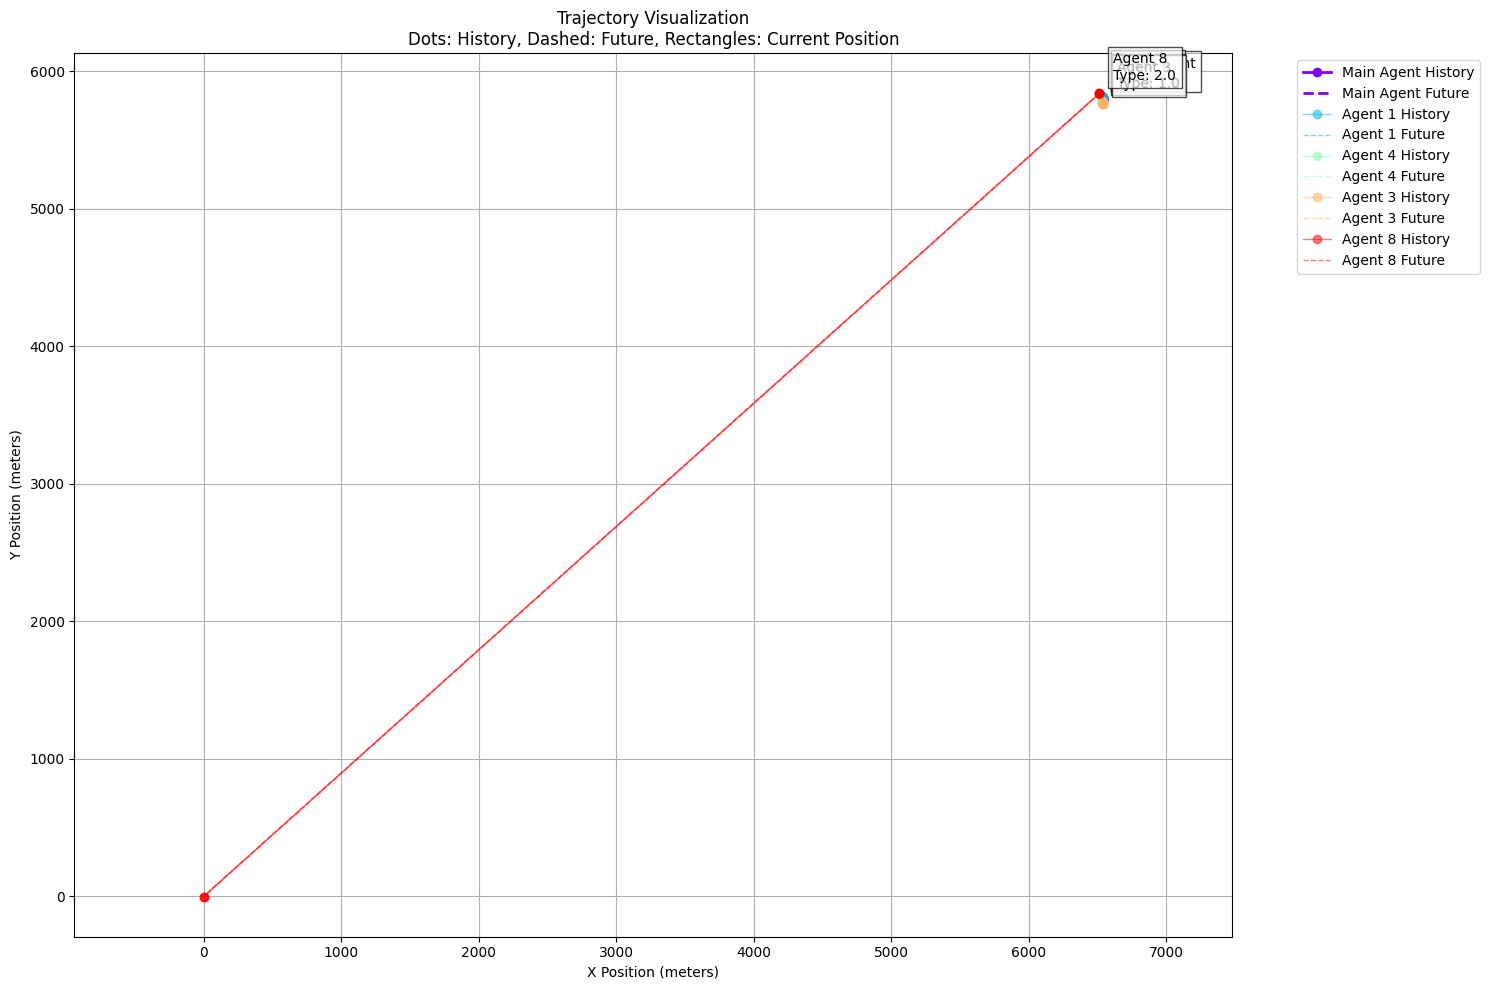

In [41]:
visualize_npz_data("processed_data/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00010-of-01000.npz")

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def visualize_npz_data(npz_path, scene_idx=0, agent_ids=None, only_sdc=False, show_all=False):
    """
    Visualize trajectory data from NPZ file with enhanced agent selection.
    
    Args:
        npz_path: Path to the NPZ file
        scene_idx: Which scene to visualize if multiple scenes exist
        agent_ids: List of specific agent IDs to visualize (optional)
        only_sdc: If True, only show the self-driving car trajectory
        show_all: If True, show all valid agents (might be cluttered)
    """
    # Load the data
    data = np.load(npz_path)
    
    # Create a figure
    plt.figure(figsize=(15, 10))
    
    # Find the SDC (main agent)
    # Since we don't have direct SDC flag, we'll use tracks_to_predict or first valid agent
    valid_agents = np.where(data['agent_valid'])[0]
    sdc_idx = valid_agents[0] if len(valid_agents) > 0 else None
    
    # Determine which agents to plot
    if only_sdc and sdc_idx is not None:
        agents_to_plot = [sdc_idx]
    elif agent_ids is not None:
        agents_to_plot = [idx for idx in agent_ids if idx in valid_agents]
    elif show_all:
        agents_to_plot = valid_agents
    else:
        # Default: show first valid agent and 4 closest agents
        if sdc_idx is not None:
            current_sdc_pos = data['history/xy'][sdc_idx, -1]
            distances = []
            for idx in valid_agents:
                if idx != sdc_idx:
                    pos = data['history/xy'][idx, -1]
                    dist = np.linalg.norm(pos - current_sdc_pos)
                    distances.append((idx, dist))
            distances.sort(key=lambda x: x[1])
            closest_agents = [d[0] for d in distances[:4]]
            agents_to_plot = [sdc_idx] + closest_agents
        else:
            agents_to_plot = valid_agents[:5]
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(agents_to_plot)))
    
    # Plot each selected agent
    for idx, agent_idx in enumerate(agents_to_plot):
        # Get agent dimensions
        width = data['width'][agent_idx]
        length = data['length'][agent_idx]
        
        # Determine if this is the main agent (first valid agent)
        is_main = agent_idx == sdc_idx
        
        # Set line properties based on agent type
        line_width = 2 if is_main else 1
        alpha = 1.0 if is_main else 0.5
        
        # Plot history trajectory
        history = data['history/xy'][agent_idx]
        history_valid = data['history/valid'][agent_idx]
        valid_history = history[history_valid == 1]
        
        label_prefix = 'Main Agent' if is_main else f'Agent {agent_idx}'
        plt.plot(valid_history[:, 0], valid_history[:, 1], 
                'o-', color=colors[idx], alpha=alpha, linewidth=line_width,
                label=f'{label_prefix} History')
        
        # Plot future trajectory
        future = data['future/xy'][agent_idx]
        future_valid = data['future/valid'][agent_idx]
        valid_future = future[future_valid == 1]
        
        plt.plot(valid_future[:, 0], valid_future[:, 1], 
                '--', color=colors[idx], alpha=alpha, linewidth=line_width,
                label=f'{label_prefix} Future')
        
        # Plot current position with vehicle rectangle
        current_pos = history[-1]
        current_yaw = data['history/yaw'][agent_idx][-1]
        
        # Create rectangle for vehicle
        rect = Rectangle(
            (current_pos[0] - length/2, current_pos[1] - width/2),
            length, width,
            angle=np.degrees(current_yaw),
            color=colors[idx],
            alpha=0.7,
            linewidth=2 if is_main else 1
        )
        plt.gca().add_patch(rect)
        
        # Add agent information
        agent_type = data['agent_type'][agent_idx]
        label_text = f'{"Main Agent" if is_main else f"Agent {agent_idx}"}\nType: {agent_type}'
        plt.annotate(label_text, 
                    (current_pos[0], current_pos[1]),
                    xytext=(10, 10), 
                    textcoords='offset points',
                    bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title('Trajectory Visualization\nDots: History, Dashed: Future, Rectangles: Current Position')
    plt.xlabel('X Position (meters)')
    plt.ylabel('Y Position (meters)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Print additional information
    print(f"\nScene Information:")
    print(f"Scenario ID: {data['scenario_id']}")
    print(f"Total number of valid agents: {len(valid_agents)}")
    print(f"Time spans:")
    print(f"- History: {data['history/xy'].shape[1]} timesteps (~{data['history/xy'].shape[1]/10:.1f} seconds)")
    print(f"- Future: {data['future/xy'].shape[1]} timesteps (~{data['future/xy'].shape[1]/10:.1f} seconds)")
    
    plt.tight_layout()
    plt.show()


Scene Information:
Scenario ID: 64f6f10cab29e826
Total number of valid agents: 8
Time spans:
- History: 11 timesteps (~1.1 seconds)
- Future: 80 timesteps (~8.0 seconds)


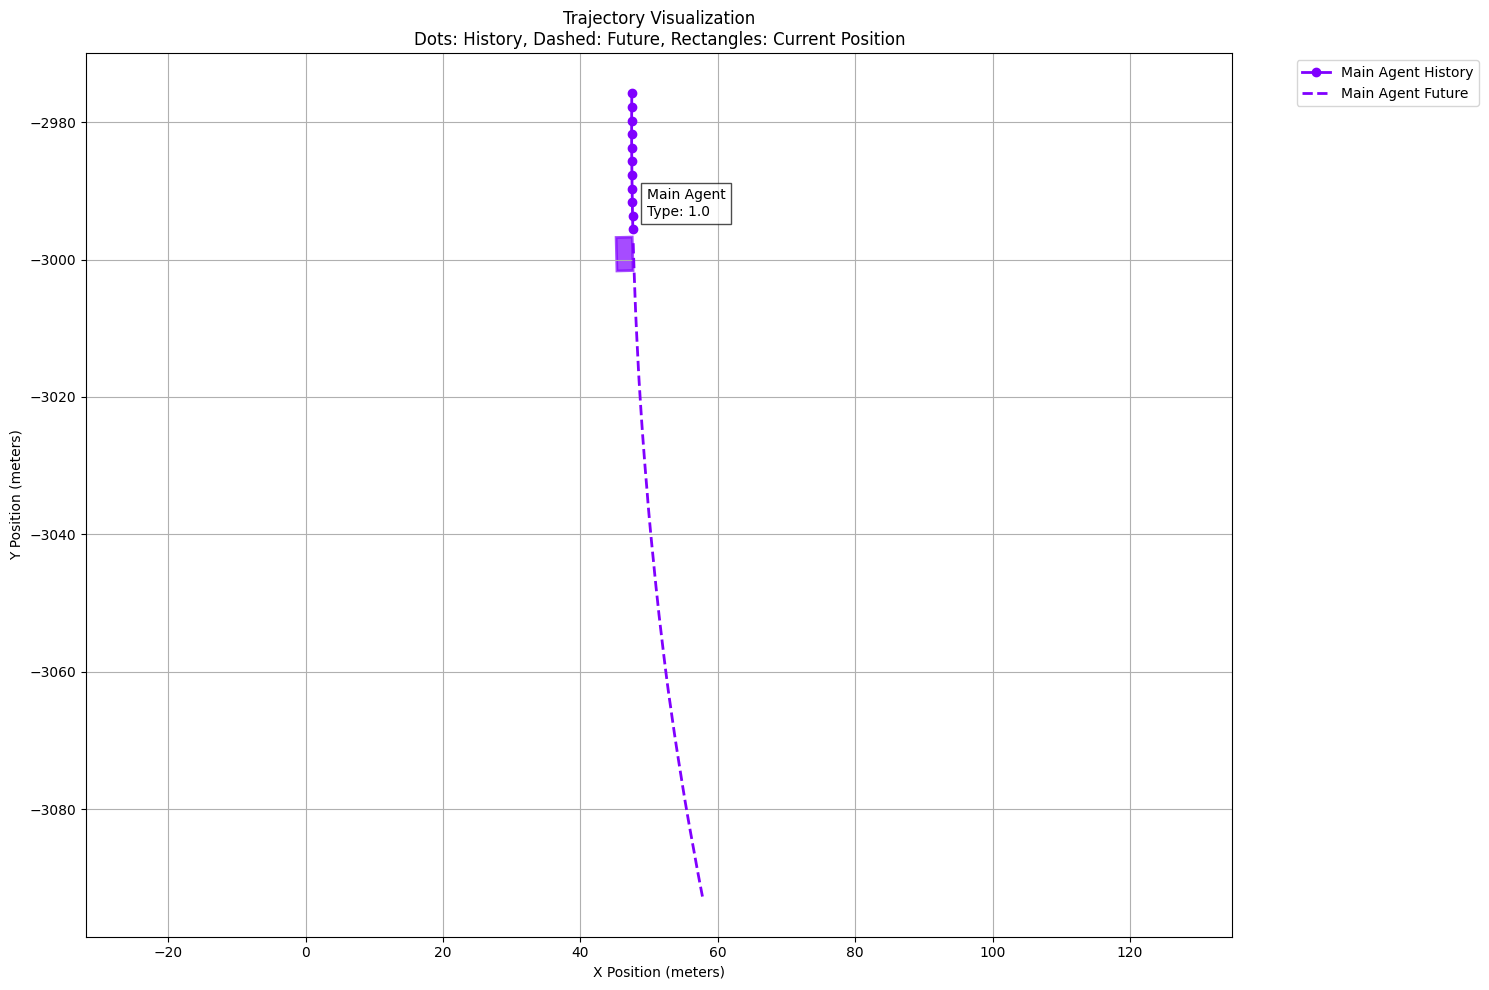

In [14]:
visualize_npz_data("processed_data/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00001-of-01000.npz" , only_sdc=True)


Scene Information:
Scenario ID: 2e8cb08945e3186f
Total number of valid agents: 15
Time spans:
- History: 11 timesteps (~1.1 seconds)
- Future: 80 timesteps (~8.0 seconds)


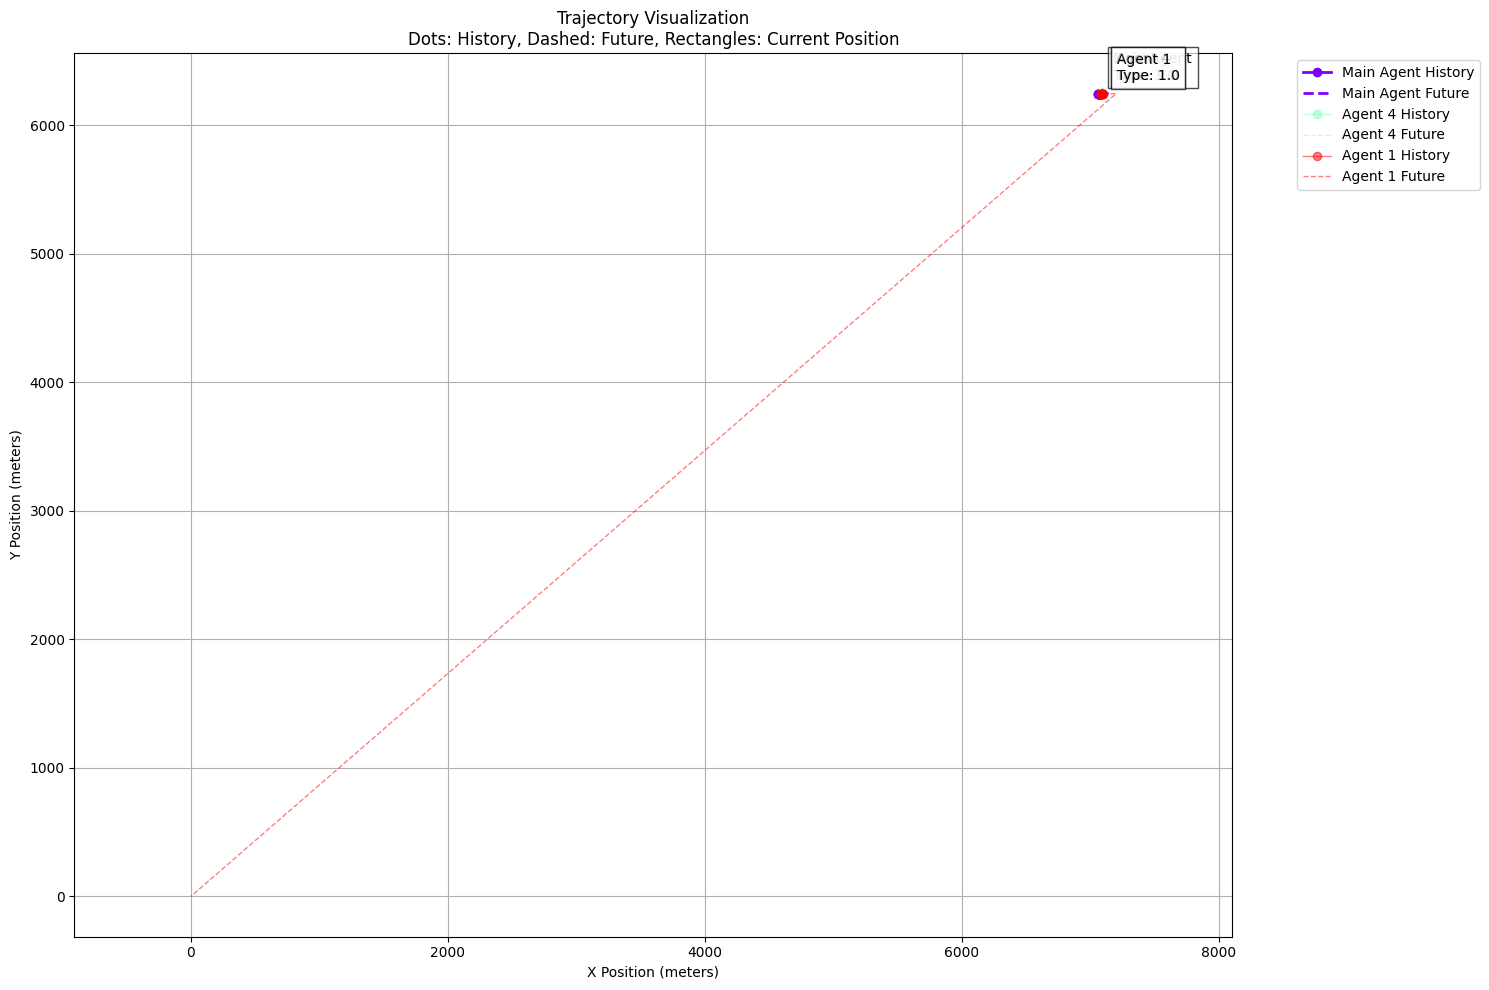

In [12]:
visualize_npz_data("processed_data/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00003-of-01000.npz" , agent_ids=[0, 4, 1])